In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings("ignore") 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings

import sys, os
import time
import keras
import seaborn as sns
import numpy as np
import pandas as pd 
from keras.callbacks import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from neuralnetworks.neuralnetwork import NeuralNetwork
from keras.models import Sequential
from keras.layers import *
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.optimizers import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from keras.optimizers import *
from neuralnetworks.neuralnetwork import print_confusion_matrix
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle

# Allow dynamic allocation and memory growth on tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 11)

# Fix random seed for reproducibility
randSeed = 42
np.random.seed(randSeed)

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


Em um problema real de Redes Neurais, normalmente uma instância pode possuir inúmeras entradas, resultando em uma arquitetura de rede extensa com muitos neurônios e de múltiplas camadas. 

Um exemplo comum de aplicação nesse escopo é um classificador de imagens, em que cada entrada representa um neurônio da camada de entrada. Sabendo disso, esse notebook tem como objetivo implementar uma Rede Neural Multicamada (MLP) para o dataset MNIST. O MNIST é um dataset de dígitos escritos a mão, conforme Figura 1. 

A MLP deve ser implementada de forma a utilizar uma arquitetura simples e ainda, assim, obter uma performance elevada. Ao final, três modelos de rede devem ser implementados e comparados. Os detalhes de implementação devem ser justificados a cada questão e será dividido em 5 etapas:
* Leitura, visualização e Préprocessamento do dataset
* Conversão do array de predições Y
* Definição da topologia da rede (camadas e neurônios)
* Definir otimizador, função custo e modo do treinamento (batch, mini-batch, estocástico)
* Treinamento e avaliação de resultados

![alt text](../imgs/mninst.png "Title")

# Leitura, visualização e pré-processamento do dataset

Ao utilizar Redes Neurais para imagens, cada entrada é um pixel. Dessa forma, após a leitura do dataset, precisa-se descobrir as dimensões da imagem, a quantidade de instâncias, quantas classes e entradas são necessárias para o problema.

Feito isso, algumas técnicas de pré-processamento devem ser utilizadas para melhores resultados, dentre eles converter a imagem para tons de cinza e normalizar.

Sabendo disso, retorne na célula abaixo essas informações e gere uma versão normalizada do dataset 


Visualização depois da normalização: 



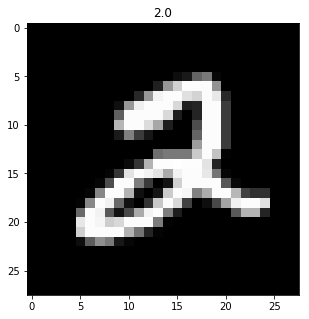

In [2]:
### leitura do dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Converte para float32 para evitar um bug com o tensorflow na GPU
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

### Normalizar
x_train = x_train/255   # simplemente divido por 255, forçando a entrada ser sempre de 0 a 1.
x_test =  x_test/255    # simplemente divido por 255, forçando a entrada ser sempre de 0 a 1.

### Visualizar instâncias
print("Visualização depois da normalização: \r\n")
pylab.rcParams['figure.figsize'] = (5, 5)
plt.imshow(x_train[5], cmap=plt.get_cmap('gray'))
plt.title(y_train[5])
plt.show()

# Conversão do array de predições Y

** Baseado no número de classes do problema, represente a saída como one-hot encoding. Indique a importância dessa representação.**

**Resposta: ** Atributos categóricos precisam ser representados numericamente. Caso não codificarmos cada categoria em um novo atributo separadamente, a rede pode interpretar que a posição ou a ordem dos números tem algum significado. Ao codificar as categorias separadamente, facilitamos o aprendizado da rede e resolvemos o problema mencionado anteriormente.

In [3]:
def one_hot(true_labels, num_classes):
    """
    Função que implementa o one-hot encoding
    Entrada: true_labels - array original com os labels
    Retorna: labels - conversão one-hot          
    """    
    return keras.utils.to_categorical(true_labels, num_classes)

print("Antes de converter: \r\n", y_train[:10], "\r\n")

y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)

print("Depois de converter: \r\n",y_train[:10])

Antes de converter: 
 [ 5.  0.  4.  1.  9.  2.  1.  3.  1.  4.] 

Depois de converter: 
 [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


# Definição de Topologia da Rede

Mostre as três arquiteturas que serão utilizadas para resolver o problema. As arquiteturas devem ser simples de forma a retornar bons resultados com a menor quantidade necessária de neurônios e camadas. As três arquiteturas devem variar apenas quanto ao número de neurônios e camadas (incluindo regularização). Baseado nisso, explique:

**Quantos neurônios serão utilizados em cada camada? **

Vamos criar 3 redes com as seguintes arquiteturas:
- Arquitetura 1: 256 10
- Arquitetura 2: 512 10
- Arquitetura 3: 512 512 10
    
**Quantas camadas serão utilizadas?**

- Arquitetura 1: 2
- Arquitetura 2: 2
- Arquitetura 3: 3

**É necessário utilizar regularização? Se sim explique a técnica que foi utilizada e o impacto nos resultados**

Sim. A fim de evitarmos overfiting, resolvemos adicionar uma camada **Dropout (0.3)** entre as camadas densas da rede. A regularização por Dropout desativa aleatoriamente neurônios e com isso espera-se que essa medida aumente a capacidade de a rede generalizar.

A adição do Dropout fez com que o overfitting acontecesse de maneira mais tardia, permitindo que a rede generalizasse mais. A imagem abaixo mostra uma comparação entre duas versões sendo executadas, uma com dropout e outra sem. O uso do dropout permitiu a rede sua acurácia no dataset de validação aumentada em cerca de 0.5%.

![dropout](../imgs/l2q1-dropout-ou-sem-dropout.jpg)


Uma outra técnica de regularização que utilizamos foi a utilização de técnicas de **Data Aumentation**. O Objetivo foi gerar multiplas imagens com pequenas variações a fim de aumentar o dataset de treinamento, reduzindo a função de perda no dataset de validação mas nao no de treinamento. Atravez da técnica aumentamos o dataset de treinamento de 50.000 para **5 milhoes de imagens**.
As variações introduzidas foram de zoom, largura e altura. O impacto foi pequeno mas foi possivel ver um aumento de até 0.4% na precisão no dataset de validação.


**Qual função de ativação será utilizada? Escolha duas funções de ativação e explique os resultados obtidos**

Abaixo listo dois exemplos de função de ativação:

**ReLu:** Função de ativação bastante utilizada. Possui comportamento linear para x >= 0 e tem seu valor zerado para qualquer número menor que zero. Seu cálculo e o calculo de sua derivada é trivial, diminuindo o processamento necessário para o treinamento. Além disso, a derivada de sua parte positiva é sempre 1, fazendo com que essa função de ativação seja uma boa escolha em casos em que a rede possua muitas camadas.

**Softmax:** Utilizada geralmente na última camada de redes em problemas de classificação com múltiplas classes. Ela garante que a soma das saídas fique entre 0 e 1 e, além disso, a soma dos valores de saída dá 1. Essas características facilitam o mapeamento da saída da rede para classes.

Sendo assim, escolhemos a Softmax como função de ativação da ultima camada da rede e a ReLu para todas as outras camadas. As funções se comportaram da maneira esperada. Os detalhes dos resultados obtidos poderão ser vistos no tópico "Resultados"

In [4]:
modelos = dict()

## Arquitetura 1: 256 10

In [5]:
# Define a arquitetura
modelo = Sequential()
modelo.add(Flatten(input_shape=(1, x_train.shape[1], x_train.shape[2],) ))
modelo.add(Dense(256, activation='relu'))
modelo.add(Dropout(0.3))
modelo.add(Dense(10, activation='softmax'))
modelo.summary()

# Adiciona a arquitetura na lista de modelos
modelos["Arquitetura 1: 256 10"] = modelo

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


## Arquitetura 2: 512 10

In [6]:
# Define a arquitetura
modelo = Sequential()
modelo.add(Flatten(input_shape=(1, x_train.shape[1], x_train.shape[2],) ))
modelo.add(Dense(512, activation='relu'))
modelo.add(Dropout(0.3))
modelo.add(Dense(10, activation='softmax'))
modelo.summary()

# Adiciona a arquitetura na lista de modelos
modelos["Arquitetura 2: 512 10"] = modelo

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


## Arquitetura 3: 512 512 10

In [7]:
# Define a arquitetura
modelo = Sequential()
modelo.add(Flatten(input_shape=(1, x_train.shape[1], x_train.shape[2],) ))
modelo.add(Dense(512, activation='relu'))
modelo.add(Dropout(0.3))
modelo.add(Dense(512, activation='relu'))
modelo.add(Dropout(0.3))
modelo.add(Dense(10, activation='softmax'))
modelo.summary()

# Adiciona a arquitetura na lista de modelos
modelos["Arquitetura 3: 512 512 10"] = modelo

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


# Definir otimizador, função custo e modo do treinamento

Uma Rede Neural é um problema de otimização, sabendo disso, explique:


** Qual otimizador será utilizado? Escolha dois otimizadores, explique a diferença entre eles justificando a escolha e comente os resultados obtidos. **

**SGD:** Stochastic gradient descent (SGD) foi o principal algoritmo aprendido em sala de aula. Em sua versão estocástica, faz a atualização dos pesos a cada exemplo. Tem dificuldades em pontos de cela visto que o gradiente fica muito pequeno.

**SGD com Momento:** A versão do SDG com momento possui uma constante do momento > 0. Tem o objetivo de aumentar a velocidade do progresso e, em caso de ajustes opostos, reduzir o tamanho da oscilação.

**Adam e RMSProp: ** São otimizadores mais recentes que tem o objetivo de adaptar o learning rate por parâmetro por guardar o histórico dos gradientes anteriores.

A fim de escolher o melhor otimizador para o problema, rodamos uma de nossas arquiteturas em cada um dos 4 otimizadores apresentados. A tabela abaixo mostra nossos resultados quando treinamos a Arquitetura 3, com 200 épocas, com o dataset de treinamento com 50.000 imagens:

| Otimizador  | Acc Train  | Acc Vali  | Acc Test  | Loss Train | Loss Vali  | Loss Test  |
|:-----------:|:----------:|:---------:|:---------:|:----------:|:----------:|:----------:|
| SGD         | 0.966      | 0.969     | 0.970     | 0.1142     | 0.1005     | 0.0977     |
| SGD+Momento | 0.981      | 0.977     | 0.977     | 0.0638     | 0.0731     | 0.0689     |
| RMSprop     | 0.999      | 0.987     | 0.985     | 0.0042     | 0.1288     | 0.1492     |
| Adam        | 0.999      | 0.985     | 0.985     | 0.0044     | 0.0965     | 0.1033     |

O otimizador **Adam** se mostrou o mais promissor e por isso o escolhemos como otimizador de todas as 3 arquiteturas.

** Será necessário utilizar uma função custo? Explique o que é uma função custo e qual será utilizada justificando a escolha. **

Sim. O objetivo da fase de treinamento é diminuir o erro, precisamos de uma função que estime esse erro. Esta, é chamada função custo (loss).
Como estamos em um problema de classificação com múltiplas classes onde a saída foi codificada utilizando a codificação "one-hot" resolvemos utilizar a função loss **categorical_crossentropy** implementada e recomendada pelo próprio keras. 

** Qual modo de treinamento foi utilizado? Justifique sua resposta ** 

Escolhemos o modo de treinamento **mini-batch** embora a rede dê bons resultados mesmo com full-batch e com o método estocástico. O total de itens por batch foi de **512**.
A fim de obtermos o máximo desempenho de nosso hardware (GPU 1080 com 8GB de memória gráfica) fomos aumentando o tamanho do batch até atingirmos um dos limites (memória gráfica ou uso do GPU).
O método mini-bath se apresentou uma escolha suficientemente boa para o problema em questão.

** Quantas épocas serão necessárias? Caso os métodos por batch ou mini-batch sejam escolhidos, indique também o tamanho**

Como escolhemos o método de **mini-batch** os pesos da rede serão atualizados múltiplas vezes durante cada época.
Mesmo quando executamos um número pequeno de épocas, a rede já dá bons resultados (>98% com apenas 5 épocas), porém, a fim de obtermos precisão máxima e a fim de compararmos as diferentes arquiteturas, escolhemos um número de épocas fixo **10**.

In [8]:
# Função loss
loss = 'categorical_crossentropy'

# Escolha das méticas
metricas = ['accuracy']

# Total de Epocas
epocas = 10

# Compilação dos modelos
for nomeDoModelo, modelo in modelos.items():
    modelo.compile(loss=loss, optimizer=Adam(lr=0.0001), metrics=metricas)

# Treinamento e avaliação dos resultados

Treine as três redes e mostre os resultados de cada uma a partir das questões anteriores.


In [9]:
treinamento = dict()

x_train, x_val, y_train, y_val = train_test_split(x_train.astype('float32'), y_train.astype('float32'), test_size=0.16666666, random_state=randSeed, shuffle=True)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

In [10]:
# Gerador de Imagens
geradorDeImagens = ImageDataGenerator(rotation_range=0, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)
geradorDeImagens.fit(x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])) 


Exemplo de 9 imagens no dataset original:


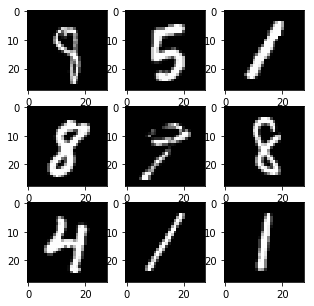


Exemplo de 9 imagens alteradas:


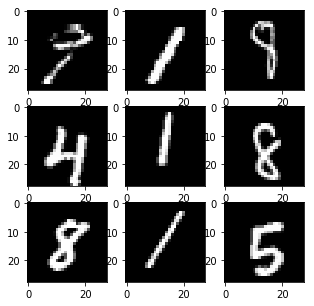


Shape do array de Treinamento:  (50000, 28, 28)

Shape do array de depois da criação de mais imagens:  (5000000, 28, 28)


In [11]:
# Mostra 9 Itens do Dataset Original
print ("\r\nExemplo de 9 imagens no dataset original:")
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

# Mostra 9 Itens do Dataset Alterado
print ("\r\nExemplo de 9 imagens alteradas:")
for x_batch, y_batch in geradorDeImagens.flow(x_train[:9].reshape(9, 1, 28, 28), y_train[:9], batch_size=9):
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(x_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    pyplot.show()
    break
    
print("\r\nShape do array de Treinamento: ", x_train.shape)

x_train_orig = numpy.copy(x_train)
y_train_orig = numpy.copy(y_train)
    
# Verifica se o cache esta presente, se não, gera as imagens e salva em cache
if (os.path.isfile("L2Q1-x_train-cache.pkl") and os.path.isfile("L2Q1-y_train-cache.pkl")):
    x_train = pickle.load(open("L2Q1-x_train-cache.pkl", "rb"))    
    y_train = pickle.load(open("L2Q1-y_train-cache.pkl", "rb"))
else:

    while len(x_train) < 5000000:
        for x_batch, y_batch in geradorDeImagens.flow(x_train_orig.reshape(x_train_orig.shape[0], 1, x_train_orig.shape[1], x_train_orig.shape[2]), y_train_orig, batch_size=50000):
            x_train = np.append(x_train, x_batch.reshape(len(x_batch), 28, 28), axis=0)
            y_train = np.append(y_train, y_batch, axis=0)
            break
        print(" - Shape do array x_train atual: ", x_train.shape)        
    pickle.dump( x_train, open("L2Q1-x_train-cache.pkl", "wb"), pickle.HIGHEST_PROTOCOL)    
    pickle.dump( y_train, open("L2Q1-y_train-cache.pkl", "wb"), pickle.HIGHEST_PROTOCOL)    
    
print("\r\nShape do array de depois da criação de mais imagens: ", x_train.shape)

# Tamanho do batch: 512
batch_size = 512

In [12]:
# Faz o treinamento de cada modelo
for nome, modelo in modelos.items():
    
    print("\r\n\r\nTreinando ", nome)  
    
    start_time = time.time()
    
    np.random.seed(randSeed)
    
    logFunction = lambda epoch, logs: sys.stdout.write('\r\r'+""+str(round( (epoch/epocas)*100))+"%" + 
                                                       ("  |  Tempo: %d s" % (time.time() - start_time)) +
                                                       ("  |  Época %d de %d" % (epoch, epocas)) + 
                                                       ("  |  Acc Train: {0:.3f}  |  Acc Val: {1:.3f}  |  Loss Train: {2:.3f}  |  Loss Val: {3:.3f}"
                                                        .format(logs['acc'], logs['val_acc'], logs['loss'], logs['val_loss'])))
    
    treinamento[nome] = modelo.fit(x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]), y_train, batch_size=batch_size, 
                                             epochs=epocas, validation_data=(x_val.reshape(len(x_val), 1, 28, 28), y_val), verbose=False, shuffle=True,
                                             callbacks=[ReduceLROnPlateau(monitor='loss', patience=100000, verbose=1, factor=0.1, min_lr=0.00001), # Apenas para fazer o log do LR
                                                 LambdaCallback(on_epoch_end=logFunction) ])
    
    # Gambiarra usada apenas para limpar o log e sobrescrever com os dados finais do treinamento
    logFunction(epocas, {'loss': treinamento[nome].history['loss'][-1], 'val_loss': treinamento[nome].history['val_loss'][-1],
                         'acc':treinamento[nome].history['acc'][-1] , 'val_acc': treinamento[nome].history['val_acc'][-1] } )



Treinando  Arquitetura 1: 256 10
100%  |  Tempo: 221 s  |  Época 10 de 10  |  Acc Train: 0.988  |  Acc Val: 0.989  |  Loss Train: 0.038  |  Loss Val: 0.043

Treinando  Arquitetura 2: 512 10
100%  |  Tempo: 238 s  |  Época 10 de 10  |  Acc Train: 0.995  |  Acc Val: 0.991  |  Loss Train: 0.015  |  Loss Val: 0.035

Treinando  Arquitetura 3: 512 512 10
100%  |  Tempo: 297 s  |  Época 10 de 10  |  Acc Train: 0.997  |  Acc Val: 0.993  |  Loss Train: 0.008  |  Loss Val: 0.036

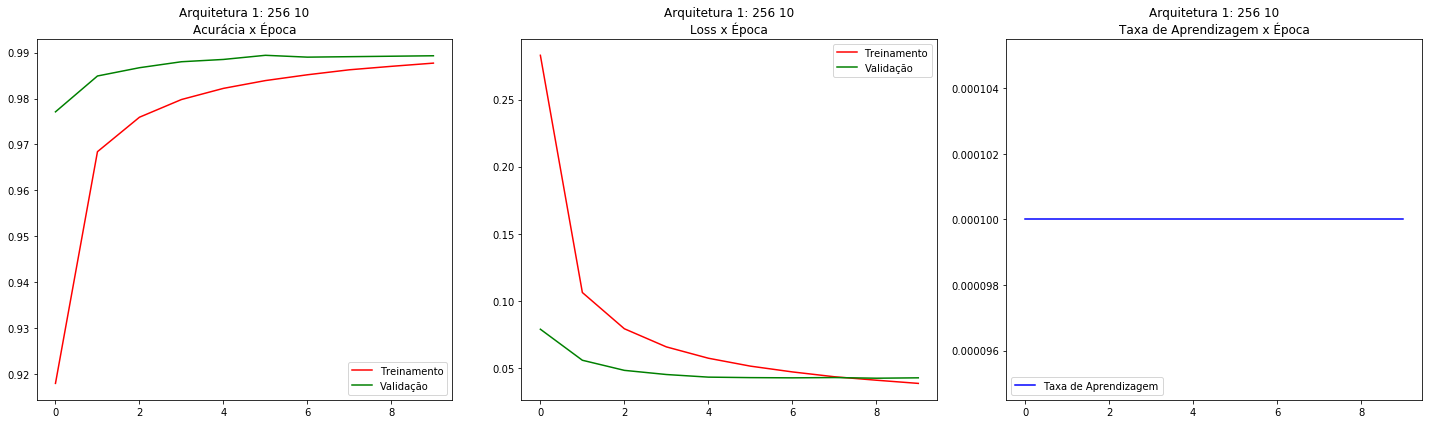

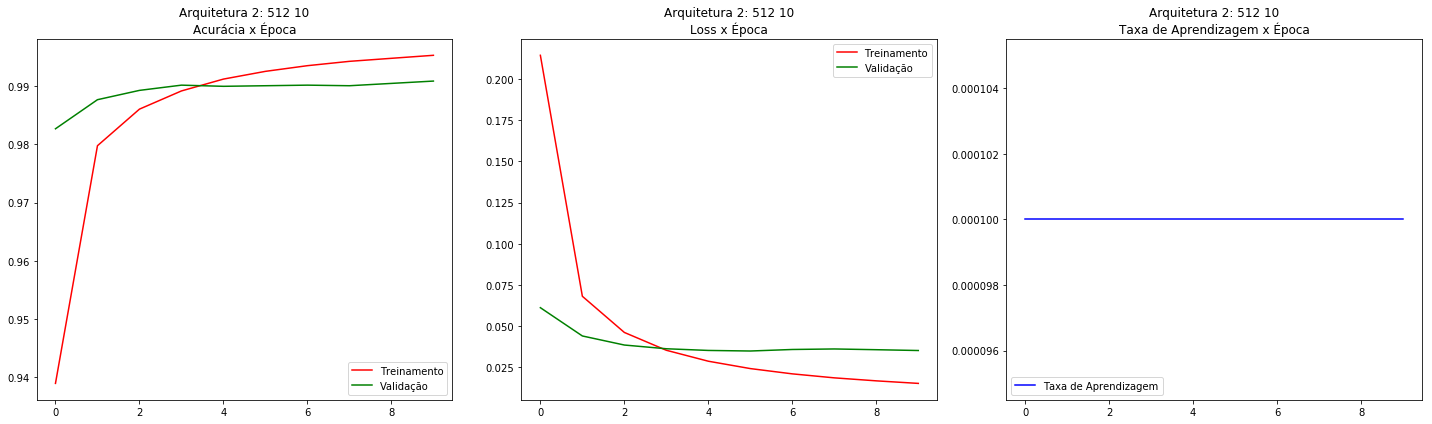

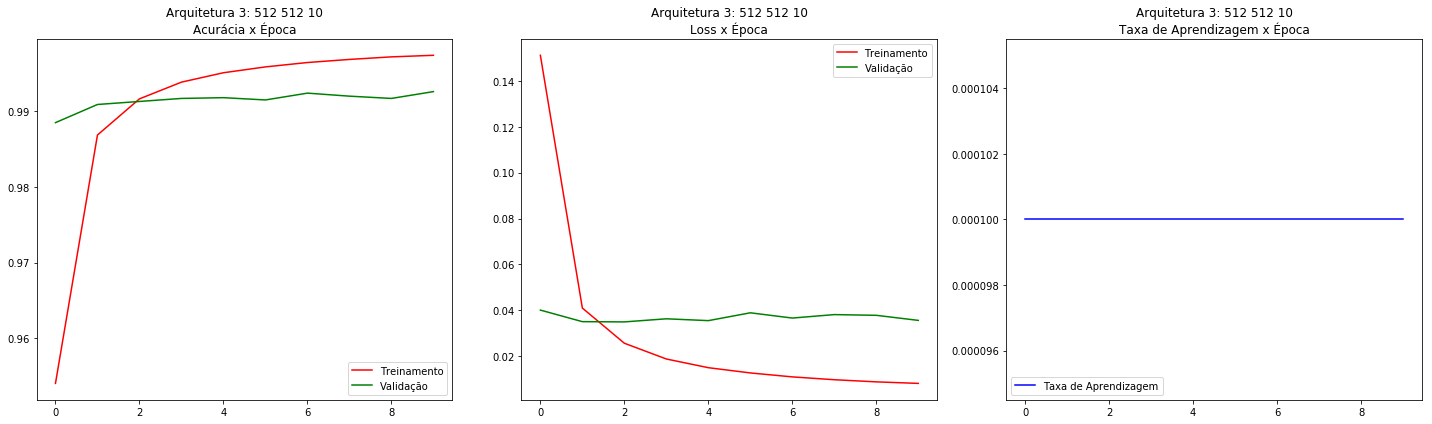

In [17]:
# Vamos agora ver os graficos de treinamento
for nome, modelo in modelos.items():
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharey=False, figsize=(20, 6))
    
    ax1.set_title(nome+'\nAcurácia x Época')
    ax1.plot(treinamento[nome].history['acc'], color="r")
    ax1.plot(treinamento[nome].history['val_acc'], color="g")
    ax1.legend(['Treinamento', 'Validação'], loc='lower right')
    
    ax2.set_title(nome+'\nLoss x Época')
    ax2.plot(treinamento[nome].history['loss'], color="r")
    ax2.plot(treinamento[nome].history['val_loss'], color="g")
    ax2.legend(['Treinamento', 'Validação'], loc='top right')
    
    ax3.set_title(nome+'\nTaxa de Aprendizagem x Época')
    ax3.plot(treinamento[nome].history['lr'], color="b")
    ax3.legend(['Taxa de Aprendizagem'], loc='lower left')
    
    plt.tight_layout()
    plt.show()
    plt.close()

## Resultados

### Accuracy e Loss

In [15]:
# Lista a accuracy e o loss de cada arquitetura no dataset de teste
for nome, modelo in modelos.items():
    print('\r\n', nome)
    score = modelo.evaluate(x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]), y_test, verbose=0)
    print('  Loss: {0:.3f}\r\n  Accuracy: {1:.3f}'.format(score[0], score[1]))


 Arquitetura 1: 256 10
  Loss: 0.038
  Accuracy: 0.988

 Arquitetura 2: 512 10
  Loss: 0.032
  Accuracy: 0.990

 Arquitetura 3: 512 512 10
  Loss: 0.032
  Accuracy: 0.991


### Matriz de Confusão

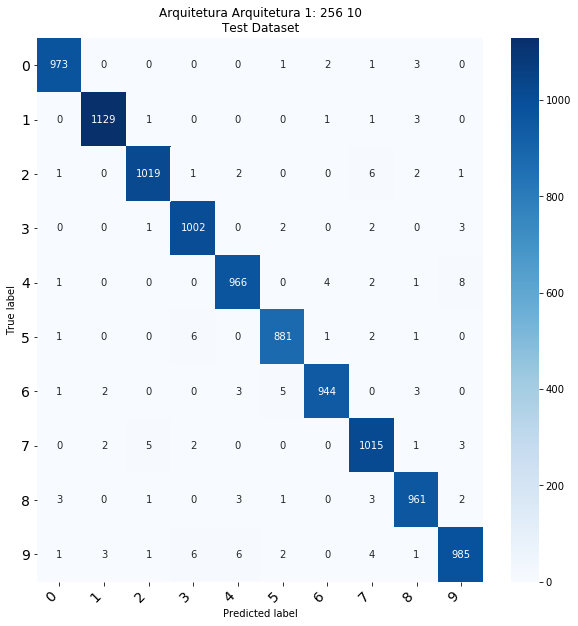

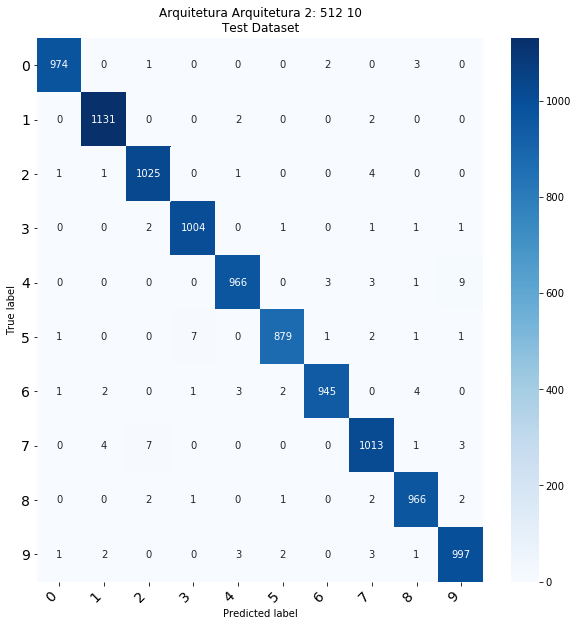

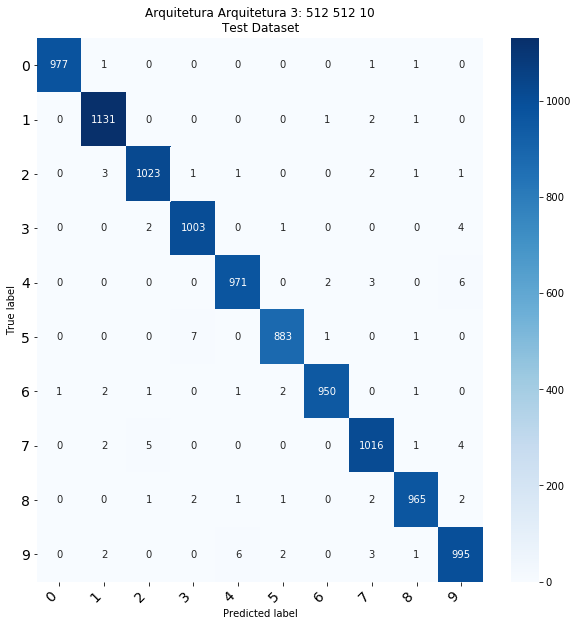

In [16]:
# Cria a matriz de confusão para cada modelo no dataset de teste
for nome, modelo in modelos.items():
    fig = print_confusion_matrix(confusion_matrix(np.argmax(y_test, axis=1),np.argmax(modelo.predict(x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])), axis=1)),
                             ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'), cmap="Blues", vmin=0, ax=None, figsize = (10,10), title="Arquitetura " + nome+"\nTest Dataset")

## Conclusão

Os resultados foram excelentes. A melhor arquitetura foi a **Arquitetura 3** com ** 3 camadas (512 512 10)**. A precisão no dataset de teste foi de **99.1%** e **99.3%** no dataset de Validação. As técnicas de regularização melhoraram os nossos resultados em cerca de **0.8%** e o otimizador Adam nos permitiu uma convergência rápida.